<a href="https://colab.research.google.com/github/Savville/Structural-Machine-Learning/blob/main/ML_on_Structures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install openseespy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import openseespy.opensees as ops
import numpy as np
import matplotlib.pyplot as plt

# Clear any existing model
ops.wipe()

# Create ModelBuilder
ops.model('basic', '-ndm', 2, '-ndf', 2)

print("Creating corrected truss model based on the geometry...")

# Define nodes based on careful interpretation of the truss geometry
# Bottom chord nodes (from the coordinates shown)
ops.node(1, 0.0, 0.0)    # (0,0)
ops.node(3, 6.0, 0.0)    # (6,0)
ops.node(5, 12.0, 0.0)   # (12,0)
ops.node(7, 18.0, 0.0)   # (18,0)
ops.node(9, 24.0, 0.0)   # (24,0)
ops.node(11, 30.0, 0.0)  # (30,0)

# Top chord nodes (estimating height from triangular geometry)
height = 4.5  # Estimated truss height
ops.node(2, 3.0, height)   # (3,0) moved up
ops.node(4, 9.0, height)   # (9,0) moved up
ops.node(6, 15.0, height)  # (15,0) moved up
ops.node(8, 21.0, height)  # (21,0) moved up
ops.node(10, 27.0, height) # (27,0) moved up

# Define material properties
E = 200000.0e6  # Young's modulus (Pa) - 200 GPa
A_chord = 0.01   # Cross-sectional area for chord members (m²)
A_web = 0.005    # Cross-sectional area for web members (m²)

# Define material
ops.uniaxialMaterial('Elastic', 1, E)

# Define elements with proper connectivity
element_tag = 1

print("Creating elements...")

# Bottom chord elements (horizontal members at bottom)
bottom_connections = [(1,3), (3,5), (5,7), (7,9), (9,11)]
print("Bottom chord elements:")
for connection in bottom_connections:
    ops.element('Truss', element_tag, connection[0], connection[1], A_chord, 1)
    print(f"  Element {element_tag}: Node {connection[0]} to Node {connection[1]}")
    element_tag += 1

# Top chord elements (horizontal members at top)
top_connections = [(2,4), (4,6), (6,8), (8,10)]
print("Top chord elements:")
for connection in top_connections:
    ops.element('Truss', element_tag, connection[0], connection[1], A_chord, 1)
    print(f"  Element {element_tag}: Node {connection[0]} to Node {connection[1]}")
    element_tag += 1

# Vertical and diagonal web members (creating stable triangular patterns)
web_connections = [
    # Verticals and diagonals to create stable triangulation
    (1, 2),   # Left support to first top node
    (2, 3),   # First triangle diagonal
    (3, 4),   # Vertical-like member
    (4, 5),   # Second triangle diagonal
    (5, 6),   # Vertical-like member
    (6, 7),   # Third triangle diagonal
    (7, 8),   # Vertical-like member
    (8, 9),   # Fourth triangle diagonal
    (9, 10),  # Vertical-like member
    (10, 11), # Right support connection
    # Additional diagonals for stability
    (1, 4),   # Long diagonal
    (3, 6),   # Long diagonal
    (5, 8),   # Long diagonal
    (7, 10),  # Long diagonal
]

print("Web elements:")
for connection in web_connections:
    ops.element('Truss', element_tag, connection[0], connection[1], A_web, 1)
    print(f"  Element {element_tag}: Node {connection[0]} to Node {connection[1]}")
    element_tag += 1

# Apply boundary conditions
print("\nApplying boundary conditions...")
# Pin support at node 1 (left end)
ops.fix(1, 1, 1)  # Fixed in both x and y directions
print("  Node 1: Pinned support (fixed in X and Y)")

# Roller support at node 11 (right end)
ops.fix(11, 0, 1)  # Fixed in y direction, free in x direction
print("  Node 11: Roller support (fixed in Y, free in X)")

# Define loads
ops.timeSeries('Linear', 1)
ops.pattern('Plain', 1, 1)

# Apply point loads at top chord nodes
load_magnitude = -10000.0  # 10 kN downward
loaded_nodes = [2, 4, 6, 8, 10]
print(f"\nApplying loads ({load_magnitude/1000:.0f} kN downward):")
for node in loaded_nodes:
    ops.load(node, 0.0, load_magnitude)
    print(f"  Node {node}: {load_magnitude/1000:.0f} kN")

# Analysis setup with more robust settings
print("\nSetting up analysis...")
ops.constraints('Transformation')  # Better constraint handler
ops.numberer('RCM')
ops.system('BandGeneral')  # More robust system solver
ops.test('NormDispIncr', 1.0e-6, 50)  # Relaxed tolerance, more iterations
ops.algorithm('Newton')
ops.integrator('LoadControl', 0.1)  # Smaller load steps
ops.analysis('Static')

# Run analysis with load stepping
print("Running static analysis...")
success = True
for step in range(10):  # 10 load steps of 0.1 each = 1.0 total
    result = ops.analyze(1)
    if result != 0:
        print(f"  Analysis failed at step {step+1}")
        success = False
        break
    else:
        print(f"  Load step {step+1}/10 completed")

if success:
    print("Static analysis completed successfully!")

    # Get results
    print("\nStatic Analysis Results:")
    print("========================")

    # Node displacements
    print("\nNode Displacements:")
    print("Node\tX-Disp (mm)\tY-Disp (mm)")
    print("-" * 35)

    all_nodes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    max_disp = 0

    for node in all_nodes:
        disp = ops.nodeDisp(node)
        max_disp = max(max_disp, abs(disp[0]), abs(disp[1]))
        print(f"{node}\t{disp[0]*1000:.3f}\t\t{disp[1]*1000:.3f}")

    # Element forces
    print("\nElement Forces:")
    print("Element\tAxial Force (kN)")
    print("-" * 25)

    max_force = 0
    for elem in range(1, element_tag):
        force = ops.eleForce(elem)
        max_force = max(max_force, abs(force[0]))
        force_kN = force[0] / 1000.0
        status = "Tension" if force[0] > 0 else "Compression" if force[0] < 0 else "Zero"
        print(f"{elem}\t{force_kN:.2f} ({status})")

    # Reactions
    print("\nSupport Reactions:")
    print("Node\tRx (kN)\t\tRy (kN)")
    print("-" * 30)

    total_vertical_reaction = 0
    for node in [1, 11]:
        reaction = ops.nodeReaction(node)
        reaction_x_kN = reaction[0] / 1000.0
        reaction_y_kN = reaction[1] / 1000.0
        total_vertical_reaction += reaction_y_kN
        print(f"{node}\t{reaction_x_kN:.2f}\t\t{reaction_y_kN:.2f}")

    # Check equilibrium
    total_applied_load = len(loaded_nodes) * load_magnitude / 1000.0
    print(f"\nEquilibrium Check:")
    print(f"Total applied load: {total_applied_load:.1f} kN")
    print(f"Total vertical reactions: {total_vertical_reaction:.1f} kN")
    print(f"Difference: {abs(total_applied_load - total_vertical_reaction):.3f} kN")

    if abs(total_applied_load - total_vertical_reaction) < 0.1:
        print("✓ Equilibrium satisfied")
    else:
        print("⚠ Equilibrium not satisfied - check model")

    # Modal Analysis (if static analysis was successful)
    print("\n" + "="*50)
    print("MODAL ANALYSIS - NATURAL FREQUENCIES")
    print("="*50)

    # Add mass for dynamic analysis
    rho = 7850.0  # Steel density (kg/m³)
    volume_per_node = A_chord * 3.0  # Approximate volume per node
    node_mass = rho * volume_per_node

    print(f"Adding masses: {node_mass:.1f} kg per node")
    for node in all_nodes:
        ops.mass(node, node_mass, node_mass)

    # Perform eigenvalue analysis
    num_modes = 6
    eigenvalues = ops.eigen(num_modes)

    if eigenvalues and all(ev > 1e-10 for ev in eigenvalues):
        print(f"\nFirst {num_modes} Natural Frequencies:")
        print("Mode\tFrequency (Hz)\tPeriod (s)")
        print("-" * 35)

        frequencies = []
        for i, eigenval in enumerate(eigenvalues):
            omega = eigenval**0.5
            frequency = omega / (2 * np.pi)
            period = 1.0 / frequency
            frequencies.append(frequency)
            print(f"{i+1}\t{frequency:.3f}\t\t{period:.6f}")

        print(f"\nFrequency Summary:")
        print(f"Fundamental frequency: {frequencies[0]:.3f} Hz")
        print(f"Fundamental period: {1.0/frequencies[0]:.3f} s")

    else:
        print("Modal analysis failed - check structural stability")

else:
    print("Static analysis failed!")
    print("\nPossible issues:")
    print("1. Check element connectivity")
    print("2. Verify boundary conditions")
    print("3. Check for mechanisms in the structure")
    print("4. Review node coordinates")

# Enhanced plotting function
def plot_results():
    if not success:
        print("Cannot plot - analysis failed")
        return

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Plot 1: Undeformed structure
    ax1.set_title('Truss Geometry')
    ax1.grid(True, alpha=0.3)

    # Plot nodes
    for node in all_nodes:
        coord = ops.nodeCoord(node)
        ax1.plot(coord[0], coord[1], 'ro', markersize=8)
        ax1.text(coord[0], coord[1]+0.3, str(node), ha='center', va='bottom', fontweight='bold')

    # Plot elements
    for elem in range(1, element_tag):
        try:
            nodes = ops.eleNodes(elem)
            coord1 = ops.nodeCoord(nodes[0])
            coord2 = ops.nodeCoord(nodes[1])
            ax1.plot([coord1[0], coord2[0]], [coord1[1], coord2[1]], 'b-', linewidth=2)
        except:
            continue

    # Add support symbols
    coord1 = ops.nodeCoord(1)
    coord11 = ops.nodeCoord(11)
    ax1.plot(coord1[0], coord1[1], 's', markersize=12, color='green', label='Pin Support')
    ax1.plot(coord11[0], coord11[1], '^', markersize=12, color='orange', label='Roller Support')
    ax1.legend()
    ax1.axis('equal')

    # Plot 2: Deformed shape
    ax2.set_title(f'Deformed Shape (Max disp: {max_disp*1000:.2f} mm)')
    ax2.grid(True, alpha=0.3)

    scale_factor = 100 if max_disp > 0 else 1

    for node in all_nodes:
        coord = ops.nodeCoord(node)
        disp = ops.nodeDisp(node)
        # Original
        ax2.plot(coord[0], coord[1], 'ro', markersize=6, alpha=0.5)
        # Deformed
        new_x = coord[0] + disp[0] * scale_factor
        new_y = coord[1] + disp[1] * scale_factor
        ax2.plot(new_x, new_y, 'bo', markersize=6)

    # Plot deformed elements
    for elem in range(1, element_tag):
        try:
            nodes = ops.eleNodes(elem)
            coord1 = ops.nodeCoord(nodes[0])
            coord2 = ops.nodeCoord(nodes[1])
            disp1 = ops.nodeDisp(nodes[0])
            disp2 = ops.nodeDisp(nodes[1])

            new_x1 = coord1[0] + disp1[0] * scale_factor
            new_y1 = coord1[1] + disp1[1] * scale_factor
            new_x2 = coord2[0] + disp2[0] * scale_factor
            new_y2 = coord2[1] + disp2[1] * scale_factor

            ax2.plot([new_x1, new_x2], [new_y1, new_y2], 'b-', linewidth=2)
        except:
            continue

    ax2.axis('equal')

    # Plot 3: Force diagram
    ax3.set_title(f'Axial Forces (Max: {max_force/1000:.1f} kN)')
    ax3.grid(True, alpha=0.3)

    for elem in range(1, element_tag):
        try:
            nodes = ops.eleNodes(elem)
            coord1 = ops.nodeCoord(nodes[0])
            coord2 = ops.nodeCoord(nodes[1])
            force = ops.eleForce(elem)[0] / 1000.0  # Convert to kN

            # Color code: red for tension, blue for compression
            color = 'red' if force > 0 else 'blue'
            linewidth = min(5, max(1, abs(force) / max_force * 5)) if max_force > 0 else 1

            ax3.plot([coord1[0], coord2[0]], [coord1[1], coord2[1]],
                    color=color, linewidth=linewidth, alpha=0.7)

            # Add force labels for significant forces
            if abs(force) > max_force * 0.1:
                mid_x = (coord1[0] + coord2[0]) / 2
                mid_y = (coord1[1] + coord2[1]) / 2
                ax3.text(mid_x, mid_y, f'{force:.1f}', ha='center', va='center',
                        bbox=dict(boxstyle="round,pad=0.1", facecolor='white', alpha=0.7))
        except:
            continue

    # Add nodes
    for node in all_nodes:
        coord = ops.nodeCoord(node)
        ax3.plot(coord[0], coord[1], 'ko', markersize=6)

    ax3.axis('equal')
    ax3.text(0.02, 0.98, 'Red: Tension\nBlue: Compression',
             transform=ax3.transAxes, va='top',
             bbox=dict(boxstyle="round", facecolor='lightgray', alpha=0.7))

    # Plot 4: Load diagram
    ax4.set_title('Applied Loads')
    ax4.grid(True, alpha=0.3)

    for node in all_nodes:
        coord = ops.nodeCoord(node)
        ax4.plot(coord[0], coord[1], 'ko', markersize=6)

        if node in loaded_nodes:
            # Draw load arrow
            ax4.arrow(coord[0], coord[1], 0, -1, head_width=0.5, head_length=0.3,
                     fc='red', ec='red', linewidth=2)
            ax4.text(coord[0], coord[1]-1.5, f'{load_magnitude/1000:.0f}kN',
                    ha='center', va='top', color='red', fontweight='bold')

    # Draw structure
    for elem in range(1, element_tag):
        try:
            nodes = ops.eleNodes(elem)
            coord1 = ops.nodeCoord(nodes[0])
            coord2 = ops.nodeCoord(nodes[1])
            ax4.plot([coord1[0], coord2[0]], [coord1[1], coord2[1]], 'k-', linewidth=1, alpha=0.5)
        except:
            continue

    ax4.axis('equal')

    plt.tight_layout()
    plt.show()

# Uncomment to plot results
# plot_results()

print(f"\nModel Summary:")
print(f"- Total nodes: {len(all_nodes)}")
print(f"- Total elements: {element_tag-1}")
print(f"- Applied load: {len(loaded_nodes) * load_magnitude/1000:.0f} kN total")
print(f"- Analysis status: {'SUCCESS' if success else 'FAILED'}")

Creating corrected truss model based on the geometry...
Creating elements...
Bottom chord elements:
  Element 1: Node 1 to Node 3
  Element 2: Node 3 to Node 5
  Element 3: Node 5 to Node 7
  Element 4: Node 7 to Node 9
  Element 5: Node 9 to Node 11
Top chord elements:
  Element 6: Node 2 to Node 4
  Element 7: Node 4 to Node 6
  Element 8: Node 6 to Node 8
  Element 9: Node 8 to Node 10
Web elements:
  Element 10: Node 1 to Node 2
  Element 11: Node 2 to Node 3
  Element 12: Node 3 to Node 4
  Element 13: Node 4 to Node 5
  Element 14: Node 5 to Node 6
  Element 15: Node 6 to Node 7
  Element 16: Node 7 to Node 8
  Element 17: Node 8 to Node 9
  Element 18: Node 9 to Node 10
  Element 19: Node 10 to Node 11
  Element 20: Node 1 to Node 4
  Element 21: Node 3 to Node 6
  Element 22: Node 5 to Node 8
  Element 23: Node 7 to Node 10

Applying boundary conditions...
  Node 1: Pinned support (fixed in X and Y)
  Node 11: Roller support (fixed in Y, free in X)

Applying loads (-10 kN downw

In [3]:
import openseespy.opensees as ops
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
import json

print("="*60)
print("STRUCTURAL HEALTH MONITORING DATA GENERATION")
print("AI-Based Damage Detection Using Modal Frequencies")
print("="*60)

def create_truss_model(temperature_factor=1.0):
    """
    Create the baseline truss model with optional temperature effect simulation.
    temperature_factor: Multiplier for Young's Modulus to simulate temperature changes.
    """
    ops.wipe()
    ops.model('basic', '-ndm', 2, '-ndf', 2)

    # Define nodes (same as corrected model)
    ops.node(1, 0.0, 0.0)
    ops.node(3, 6.0, 0.0)
    ops.node(5, 12.0, 0.0)
    ops.node(7, 18.0, 0.0)
    ops.node(9, 24.0, 0.0)
    ops.node(11, 30.0, 0.0)

    height = 4.5
    ops.node(2, 3.0, height)
    ops.node(4, 9.0, height)
    ops.node(6, 15.0, height)
    ops.node(8, 21.0, height)
    ops.node(10, 27.0, height)

    # Material properties (adjusted by temperature factor)
    E_base = 200000.0e6  # Pa
    E = E_base * temperature_factor
    A_chord = 0.01  # m²
    A_web = 0.005   # m²

    ops.uniaxialMaterial('Elastic', 1, E)

    return A_chord, A_web, E_base # Return base E for calculating temperature effects

def create_elements(A_chord, A_web, damaged_elements=None, damage_percentages=None):
    """
    Create elements with optional damage simulation.
    damaged_elements: List of element tags to damage.
    damage_percentages: List of damage percentages corresponding to damaged_elements.
    """
    element_tag = 1
    element_info = {}

    if damaged_elements is None:
        damaged_elements = []
    if damage_percentages is None:
        damage_percentages = []

    # Combine damage info into a dictionary for easier lookup
    damage_dict = dict(zip(damaged_elements, damage_percentages))


    # Bottom chord elements
    bottom_connections = [(1,3), (3,5), (5,7), (7,9), (9,11)]
    for connection in bottom_connections:
        area = A_chord
        damage_pct = damage_dict.get(element_tag, 0.0)
        area *= (1 - damage_pct/100.0)  # Reduce area to simulate damage

        ops.element('Truss', element_tag, connection[0], connection[1], area, 1)
        element_info[element_tag] = {
            'nodes': connection,
            'type': 'bottom_chord',
            'original_area': A_chord,
            'actual_area': area,
            'damage_applied_pct': damage_pct # Record applied damage
        }
        element_tag += 1

    # Top chord elements
    top_connections = [(2,4), (4,6), (6,8), (8,10)]
    for connection in top_connections:
        area = A_chord
        damage_pct = damage_dict.get(element_tag, 0.0)
        area *= (1 - damage_pct/100.0)

        ops.element('Truss', element_tag, connection[0], connection[1], area, 1)
        element_info[element_tag] = {
            'nodes': connection,
            'type': 'top_chord',
            'original_area': A_chord,
            'actual_area': area,
            'damage_applied_pct': damage_pct
        }
        element_tag += 1

    # Web elements
    web_connections = [
        (1, 2), (2, 3), (3, 4), (4, 5), (5, 6),
        (6, 7), (7, 8), (8, 9), (9, 10), (10, 11)
    ]
    for connection in web_connections:
        area = A_web
        damage_pct = damage_dict.get(element_tag, 0.0)
        area *= (1 - damage_pct/100.0)

        ops.element('Truss', element_tag, connection[0], connection[1], area, 1)
        element_info[element_tag] = {
            'nodes': connection,
            'type': 'web_member',
            'original_area': A_web,
            'actual_area': area,
            'damage_applied_pct': damage_pct
        }
        element_tag += 1

    return element_tag - 1, element_info

def apply_boundary_and_loads():
    """Apply supports and loads"""
    # Boundary conditions
    ops.fix(1, 1, 1)  # Pin
    ops.fix(11, 0, 1)  # Roller

    # Add masses for modal analysis
    rho = 7850.0  # kg/m³
    node_mass = 100.0  # kg per node
    all_nodes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

    for node in all_nodes:
        ops.mass(node, node_mass, node_mass)

def extract_modal_data(num_modes=6): # Reduced modes to 6 for faster generation
    """Extract natural frequencies and mode shapes"""
    eigenvalues = ops.eigen(num_modes)

    if not eigenvalues or any(ev <= 0 for ev in eigenvalues):
        return None, None

    frequencies = []
    mode_shapes = {}
    all_nodes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

    for i, eigenval in enumerate(eigenvalues):
        omega = eigenval**0.5
        frequency = omega / (2 * np.pi)
        frequencies.append(frequency)

        # Get mode shapes for each node
        mode_shapes[i+1] = {}
        for node in all_nodes:
            try:
                shape = ops.nodeEigenvector(node, i+1)
                mode_shapes[i+1][node] = {
                    'x_shape': shape[0],
                    'y_shape': shape[1]
                }
            except:
                 mode_shapes[i+1][node] = {'x_shape': 0.0, 'y_shape': 0.0} # Handle potential errors


    return frequencies, mode_shapes

def generate_damage_dataset():
    """Generate comprehensive dataset for AI training"""
    print("Generating comprehensive dataset for AI-based damage detection...")

    dataset = []
    all_nodes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    num_modes_to_extract = 6 # Consistent number of modes

    # Define temperature variations (as factors of E)
    # 1.0 is baseline, <1.0 for reduced E (higher temp), >1.0 for increased E (lower temp)
    temperature_factors = [0.98, 1.0, 1.02] # Approx +/- 10 deg C change for steel

    # Get baseline (healthy) structure data at baseline temperature (temp_factor = 1.0)
    print("Analyzing healthy structure at baseline temperature...")
    A_chord, A_web, E_base = create_truss_model(temperature_factor=1.0)
    total_elements, element_info_base = create_elements(A_chord, A_web) # Use base element info for reference
    apply_boundary_and_loads()

    # Setup analysis
    ops.constraints('Transformation')
    ops.numberer('RCM')
    ops.system('BandGeneral')

    baseline_freq_dict = {}
    baseline_modes_dict = {}

    # Get baseline frequencies for each temperature factor
    for temp_factor in temperature_factors:
        ops.wipe() # Clear previous model
        A_chord, A_web, E_base_temp = create_truss_model(temperature_factor=temp_factor) # Use temp_factor
        create_elements(A_chord, A_web) # No damage
        apply_boundary_and_loads()

        ops.constraints('Transformation')
        ops.numberer('RCM')
        ops.system('BandGeneral')

        freq, modes = extract_modal_data(num_modes=num_modes_to_extract)
        if freq is None:
            print(f"❌ Failed to extract baseline frequencies for temp factor {temp_factor}")
            continue
        baseline_freq_dict[temp_factor] = freq
        baseline_modes_dict[temp_factor] = modes
        print(f"✓ Baseline frequencies for temp factor {temp_factor}: {[f'{f:.3f}' for f in freq]} Hz")


    # Generate damage scenarios (Single Element Damage)
    print("\nGenerating single-element damage scenarios...")
    damage_percentages_single = list(range(1, 21)) # 1% to 20% in 1% increments

    for element_num in range(1, total_elements + 1):
        for damage_pct in damage_percentages_single:
             for temp_factor in temperature_factors: # Include temperature variations
                print(f"Analyzing damage: Element {element_num}, {damage_pct}%, Temp Factor {temp_factor}...")

                # Create model with damage and temperature effect
                ops.wipe()
                A_chord, A_web, _ = create_truss_model(temperature_factor=temp_factor) # Use temp_factor
                _, element_info = create_elements(A_chord, A_web,
                                                damaged_elements=[element_num],
                                                damage_percentages=[damage_pct])
                apply_boundary_and_loads()

                # Setup analysis
                ops.constraints('Transformation')
                ops.numberer('RCM')
                ops.system('BandGeneral')

                # Extract modal data
                damaged_freq, damaged_modes = extract_modal_data(num_modes=num_modes_to_extract)

                if damaged_freq is None:
                    print(f"  ❌ Failed for element {element_num}, {damage_pct}%, Temp Factor {temp_factor}")
                    continue

                # Create data row
                data_row = {
                    'damage_type': 'single_element',
                    'damaged_elements': [element_num],
                    'damage_percentages': [damage_pct],
                    'temperature_factor': temp_factor,
                    'case_description': f'Element {element_num} - {damage_pct}% damage, Temp Factor {temp_factor}'
                }

                # Add frequencies and frequency changes relative to the baseline at *that temperature*
                baseline_freq_at_temp = baseline_freq_dict[temp_factor]
                baseline_modes_at_temp = baseline_modes_dict[temp_factor]

                for i, (freq, base_freq) in enumerate(zip(damaged_freq, baseline_freq_at_temp)):
                    data_row[f'frequency_{i+1}'] = freq
                    data_row[f'freq_change_{i+1}'] = freq - base_freq
                    # Avoid division by zero if baseline freq is zero or very small
                    data_row[f'freq_change_pct_{i+1}'] = ((freq - base_freq) / base_freq) * 100 if base_freq != 0 else 0.0

                # Add mode shapes and mode shape changes relative to the baseline at *that temperature*
                for mode in range(1, num_modes_to_extract + 1):
                    for node in all_nodes:
                        data_row[f'mode_{mode}_node_{node}_x'] = damaged_modes[mode][node]['x_shape']
                        data_row[f'mode_{mode}_node_{node}_y'] = damaged_modes[mode][node]['y_shape']

                        baseline_x = baseline_modes_at_temp[mode][node]['x_shape']
                        baseline_y = baseline_modes_at_temp[mode][node]['y_shape']
                        data_row[f'mode_change_{mode}_node_{node}_x'] = damaged_modes[mode][node]['x_shape'] - baseline_x
                        data_row[f'mode_change_{mode}_node_{node}_y'] = damaged_modes[mode][node]['y_shape'] - baseline_y

                dataset.append(data_row)
                # print(f"  ✓ Frequency changes: {[f'{f-b:.6f}' for f, b in zip(damaged_freq, baseline_freq_at_temp)]}")


    # Generate damage scenarios (Two Element Damage)
    print("\nGenerating two-element damage scenarios...")
    damage_percentages_two = [5, 10, 15, 20] # Damage levels for two elements

    # Get all unique pairs of elements
    element_pairs = list(combinations(range(1, total_elements + 1), 2))

    for elem1, elem2 in element_pairs:
        for damage_pct1 in damage_percentages_two:
             for damage_pct2 in damage_percentages_two:
                 for temp_factor in temperature_factors: # Include temperature variations
                    print(f"Analyzing damage: Elements {elem1} & {elem2}, {damage_pct1}% & {damage_pct2}%, Temp Factor {temp_factor}...")

                    # Create model with damage and temperature effect
                    ops.wipe()
                    A_chord, A_web, _ = create_truss_model(temperature_factor=temp_factor) # Use temp_factor
                    _, element_info = create_elements(A_chord, A_web,
                                                    damaged_elements=[elem1, elem2],
                                                    damage_percentages=[damage_pct1, damage_pct2])
                    apply_boundary_and_loads()

                    # Setup analysis
                    ops.constraints('Transformation')
                    ops.numberer('RCM')
                    ops.system('BandGeneral')

                    # Extract modal data
                    damaged_freq, damaged_modes = extract_modal_data(num_modes=num_modes_to_extract)

                    if damaged_freq is None:
                        print(f"  ❌ Failed for Elements {elem1} & {elem2}, Temp Factor {temp_factor}")
                        continue

                    # Create data row
                    data_row = {
                        'damage_type': 'two_elements',
                        'damaged_elements': sorted([elem1, elem2]), # Store as sorted list
                        'damage_percentages': [damage_pct1, damage_pct2],
                         'temperature_factor': temp_factor,
                        'case_description': f'Elements {elem1},{elem2} - {damage_pct1}%,{damage_pct2}% damage, Temp Factor {temp_factor}'
                    }

                    # Add frequencies and frequency changes relative to the baseline at *that temperature*
                    baseline_freq_at_temp = baseline_freq_dict[temp_factor]
                    baseline_modes_at_temp = baseline_modes_dict[temp_factor]

                    for i, (freq, base_freq) in enumerate(zip(damaged_freq, baseline_freq_at_temp)):
                        data_row[f'frequency_{i+1}'] = freq
                        data_row[f'freq_change_{i+1}'] = freq - base_freq
                        data_row[f'freq_change_pct_{i+1}'] = ((freq - base_freq) / base_freq) * 100 if base_freq != 0 else 0.0

                    # Add mode shapes and mode shape changes relative to the baseline at *that temperature*
                    for mode in range(1, num_modes_to_extract + 1):
                        for node in all_nodes:
                            data_row[f'mode_{mode}_node_{node}_x'] = damaged_modes[mode][node]['x_shape']
                            data_row[f'mode_{mode}_node_{node}_y'] = damaged_modes[mode][node]['y_shape']

                            baseline_x = baseline_modes_at_temp[mode][node]['x_shape']
                            baseline_y = baseline_modes_at_temp[mode][node]['y_shape']
                            data_row[f'mode_change_{mode}_node_{node}_x'] = damaged_modes[mode][node]['x_shape'] - baseline_x
                            data_row[f'mode_change_{mode}_node_{node}_y'] = damaged_modes[mode][node]['y_shape'] - baseline_y


                    dataset.append(data_row)
                    # print(f"  ✓ Frequency changes: {[f'{f-b:.6f}' for f, b in zip(damaged_freq, baseline_freq_at_temp)]}")


    # Add baseline (healthy) cases for each temperature factor
    print("\nAdding healthy cases for each temperature factor...")
    for temp_factor in temperature_factors:
        baseline_freq = baseline_freq_dict[temp_factor]
        baseline_modes = baseline_modes_dict[temp_factor]

        baseline_row = {
            'damage_type': 'healthy',
            'damaged_elements': [],
            'damage_percentages': [],
            'temperature_factor': temp_factor,
            'case_description': f'Healthy Structure, Temp Factor {temp_factor}'
        }

        for i, freq in enumerate(baseline_freq):
            baseline_row[f'frequency_{i+1}'] = freq
            # Changes are zero for healthy case relative to itself
            baseline_row[f'freq_change_{i+1}'] = 0.0
            baseline_row[f'freq_change_pct_{i+1}'] = 0.0


        for mode in range(1, num_modes_to_extract + 1):
             for node in all_nodes:
                baseline_row[f'mode_{mode}_node_{node}_x'] = baseline_modes[mode][node]['x_shape']
                baseline_row[f'mode_{mode}_node_{node}_y'] = baseline_modes[mode][node]['y_shape']
                 # Changes are zero for healthy case relative to itself
                baseline_row[f'mode_change_{mode}_node_{node}_x'] = 0.0
                baseline_row[f'mode_change_{mode}_node_{node}_y'] = 0.0


        dataset.append(baseline_row)

    return dataset, element_info_base, baseline_freq_dict # Return base element info and baseline freqs per temp

def save_dataset(dataset, element_info, baseline_freq_dict):
    """Save dataset in various formats"""
    if not dataset:
        print("No dataset to save!")
        return

    # Convert to DataFrame
    df = pd.DataFrame(dataset)

    # Save as CSV
    csv_filename = 'structural_health_monitoring_dataset_extended.csv' # New filename
    df.to_csv(csv_filename, index=False)
    print(f"✓ Dataset saved as CSV: {csv_filename}")
    print(f"  - Total samples: {len(df)}")
    print(f"  - Features per sample: {len(df.columns)}")

    # Save element information
    with open('element_info.json', 'w') as f:
        json.dump(element_info, f, indent=2)
    print("✓ Element information saved: element_info.json")

    # Save baseline frequencies for each temperature factor
    with open('baseline_frequencies_extended.json', 'w') as f: # New filename
        json.dump(baseline_freq_dict, f, indent=2)
    print("✓ Baseline frequencies saved: baseline_frequencies_extended.json")

    return df

def analyze_dataset(df):
    """Analyze the generated dataset"""
    print("\n" + "="*50)
    print("DATASET ANALYSIS")
    print("="*50)

    # Basic statistics
    print(f"Total samples: {len(df)}")
    print(f"Features per sample: {len(df.columns)}")
    print(f"Unique damage types: {df['damage_type'].unique()}")
    print(f"Unique number of damaged elements: {df['damaged_elements'].apply(len).unique()}") # Analyze number of damaged elements
    print(f"Unique temperature factors: {sorted(df['temperature_factor'].unique())}")

    # For single element damage, analyze unique elements and percentages
    df_single = df[df['damage_type'] == 'single_element']
    if not df_single.empty:
        print(f"\nSingle-element damage scenarios:")
        print(f"  Unique damaged elements: {df_single['damaged_elements'].apply(lambda x: x[0]).nunique()}")
        print(f"  Damage levels: {sorted(df_single['damage_percentages'].apply(lambda x: x[0]).unique())}")

    # For two element damage, analyze unique pairs and percentages
    df_two = df[df['damage_type'] == 'two_elements']
    if not df_two.empty:
        print(f"\nTwo-element damage scenarios:")
        # Need a way to count unique pairs, storing as sorted list helps
        unique_pairs = df_two['damaged_elements'].apply(lambda x: tuple(x)).unique()
        print(f"  Unique damaged element pairs: {len(unique_pairs)}")
        print(f"  Damage levels per element: {sorted(df_two['damage_percentages'].explode().unique())}") # Explode to get all percentages

    # Frequency analysis
    freq_columns = [col for col in df.columns if col.startswith('frequency_')]
    print(f"\nFrequency features: {len(freq_columns)}")

    print("\nFrequency ranges (across all temperatures and damage states):")
    for col in freq_columns:
        print(f"  {col}: {df[col].min():.3f} - {df[col].max():.3f} Hz")

    # Frequency change analysis (relative to baseline at that temperature)
    change_columns = [col for col in df.columns if col.startswith('freq_change_') and not col.endswith('_pct')]
    print(f"\nMaximum absolute frequency changes (relative to baseline at temp):")
    for col in change_columns:
        max_change = df[col].abs().max()
        print(f"  {col}: ±{max_change:.6f} Hz")

    # Mode shape analysis
    mode_columns = [col for col in df.columns if col.startswith('mode_') and not col.startswith('mode_change_')]
    print(f"\nMode shape features: {len(mode_columns)}")

    return freq_columns, change_columns, mode_columns

def create_ai_ready_features(df):
    """Create features specifically for AI/ML algorithms"""
    print("\n" + "="*50)
    print("CREATING AI-READY FEATURE MATRIX")
    print("="*50)

    # Features for damage detection - Use changes relative to baseline at temperature
    feature_columns = []

    # Frequency changes (Hz and %)
    freq_change_cols = [col for col in df.columns if col.startswith('freq_change_')]
    feature_columns.extend(freq_change_cols)

    # Mode shape changes
    mode_change_cols = [col for col in df.columns if col.startswith('mode_change_')]
    feature_columns.extend(mode_change_cols)

    # Include temperature factor as a feature
    feature_columns.append('temperature_factor')

    # Create feature matrix
    X = df[feature_columns].values

    # Targets:
    # y_localization: Which element(s) are damaged (this is now multi-label/multi-class)
    # y_severity: Damage percentages (also multi-output)

    # For simplification in this example, let's create targets for:
    # 1. Damage Type (Healthy, Single, Two) - Classification
    # 2. Presence of Damage (Yes/No) - Binary Classification
    # 3. For damaged cases, predict damaged elements (Multi-label classification)
    # 4. For damaged cases, predict total damage percentage (Regression)

    y_damage_type = df['damage_type'].values # 'healthy', 'single_element', 'two_elements'
    y_is_damaged = (df['damage_type'] != 'healthy').astype(int).values # 0 or 1

    # For multi-label prediction of damaged elements (more complex, requires different ML approach)
    # For now, let's stick to predicting damage type and total severity.

    # Target for total severity (sum of damage percentages for damaged elements)
    # This needs careful handling for multi-element damage
    y_total_severity = df.apply(lambda row: sum(row['damage_percentages']) if row['damage_type'] != 'healthy' else 0.0, axis=1).values


    print(f"Feature matrix shape: {X.shape}")
    print(f"Features selected: {len(feature_columns)}")
    print(f"Samples: {X.shape[0]}")

    # Save feature matrix and targets
    feature_data = {
        'features': X.tolist(),
        'target_damage_type': y_damage_type.tolist(),
        'target_is_damaged': y_is_damaged.tolist(),
        'target_total_severity': y_total_severity.tolist(),
        'feature_names': feature_columns
    }

    with open('ai_features_extended.json', 'w') as f: # New filename
        json.dump(feature_data, f, indent=2)
    print("✓ AI-ready features and targets saved: ai_features_extended.json")

    return X, y_damage_type, y_is_damaged, y_total_severity, feature_columns


# Main execution
if __name__ == "__main__":
    # Generate the dataset
    dataset, element_info, baseline_freq_dict = generate_damage_dataset()

    if dataset:
        # Save dataset
        df = save_dataset(dataset, element_info, baseline_freq_dict)

        # Analyze dataset
        freq_cols, change_cols, mode_cols = analyze_dataset(df)

        # Create AI-ready features and targets for updated analysis
        X, y_damage_type, y_is_damaged, y_total_severity, feature_names = create_ai_ready_features(df)

        # Note: The sample ML code needs to be updated to handle the new targets (damage type, total severity)
        # and the inclusion of temperature_factor as a feature.
        # This will be generated in a subsequent step.

        print("\n" + "="*60)
        print("EXTENDED DATASET GENERATION COMPLETE!")
        print("="*60)
        print("Files created:")
        print("1. structural_health_monitoring_dataset_extended.csv - Main dataset")
        print("2. element_info.json - Element information")
        print("3. baseline_frequencies_extended.json - Healthy structure frequencies per temperature")
        print("4. ai_features_extended.json - AI-ready feature matrix and targets")


        print(f"\nDataset Summary:")
        print(f"- Total scenarios: {len(df)}")
        print(f"- Elements analyzed (base model): {len(element_info)}")
        print(f"- Damage types: {df['damage_type'].unique()}")
        print(f"- Damage levels (single element): {sorted(df[df['damage_type']=='single_element']['damage_percentages'].apply(lambda x: x[0]).unique())}")
        print(f"- Damage levels (two elements): {sorted(df[df['damage_type']=='two_elements']['damage_percentages'].explode().unique())}")
        print(f"- Temperature factors: {sorted(df['temperature_factor'].unique())}")
        print(f"- Features per sample: {len(feature_names)}")
        print(f"- Ready for updated AI/ML analysis!")

        # Show sample data for new columns
        print(f"\nSample of dataset with new columns:")
        display(df[['damage_type', 'damaged_elements', 'damage_percentages', 'temperature_factor', 'freq_change_1', 'freq_change_pct_1', 'mode_change_1_node_2_y']].head())


    else:
        print("❌ Dataset generation failed!")

STRUCTURAL HEALTH MONITORING DATA GENERATION
AI-Based Damage Detection Using Modal Frequencies
Generating comprehensive dataset for AI-based damage detection...
Analyzing healthy structure at baseline temperature...
✓ Baseline frequencies for temp factor 0.98: ['32.204', '70.034', '92.725', '146.439', '190.991', '200.067'] Hz
✓ Baseline frequencies for temp factor 1.0: ['32.531', '70.745', '93.667', '147.925', '192.930', '202.099'] Hz
✓ Baseline frequencies for temp factor 1.02: ['32.855', '71.449', '94.599', '149.397', '194.850', '204.109'] Hz

Generating single-element damage scenarios...
Analyzing damage: Element 1, 1%, Temp Factor 0.98...
Analyzing damage: Element 1, 1%, Temp Factor 1.0...
Analyzing damage: Element 1, 1%, Temp Factor 1.02...
Analyzing damage: Element 1, 2%, Temp Factor 0.98...
Analyzing damage: Element 1, 2%, Temp Factor 1.0...
Analyzing damage: Element 1, 2%, Temp Factor 1.02...
Analyzing damage: Element 1, 3%, Temp Factor 0.98...
Analyzing damage: Element 1, 3%, 

,damage_type,damaged_elements,damage_percentages,temperature_factor,freq_change_1,freq_change_pct_1,mode_change_1_node_2_y
0,single_element,[1],[1],0.98,-0.006256,-0.019427,-0.000009
1,single_element,[1],[1],1.00,-0.006320,-0.019427,0.027199
2,single_element,[1],[1],1.02,-0.006383,-0.019427,-0.027199
3,single_element,[1],[2],0.98,-0.012652,-0.039286,0.027209
4,single_element,[1],[2],1.00,-0.012780,-0.039286,0.027209


STRUCTURAL HEALTH MONITORING ML ANALYSIS (EXTENDED DATASET)
✓ Element information loaded.
✓ Extended Dataset loaded successfully: (9351, 287)

Feature matrix shape: (9351, 145)
Features selected (145): ['freq_change_1', 'freq_change_pct_1', 'freq_change_2', 'freq_change_pct_2', 'freq_change_3'] ... ['mode_change_6_node_10_x', 'mode_change_6_node_10_y', 'mode_change_6_node_11_x', 'mode_change_6_node_11_y', 'temperature_factor']
Damage Type target shape: (9351,)
Total Severity target shape: (9351,)

RANDOM FOREST CLASSIFICATION FOR DAMAGE TYPE

Classification Report:
                precision    recall  f1-score   support

       healthy       1.00      1.00      1.00         1
single_element       0.96      0.68      0.80       342
  two_elements       0.96      1.00      0.98      2463

      accuracy                           0.96      2806
     macro avg       0.97      0.89      0.92      2806
  weighted avg       0.96      0.96      0.95      2806


Accuracy Score: 0.95759087669280

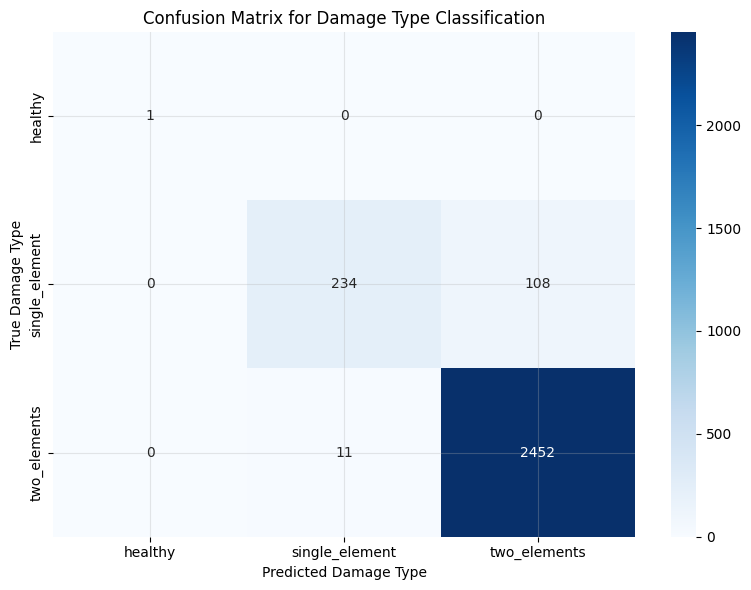

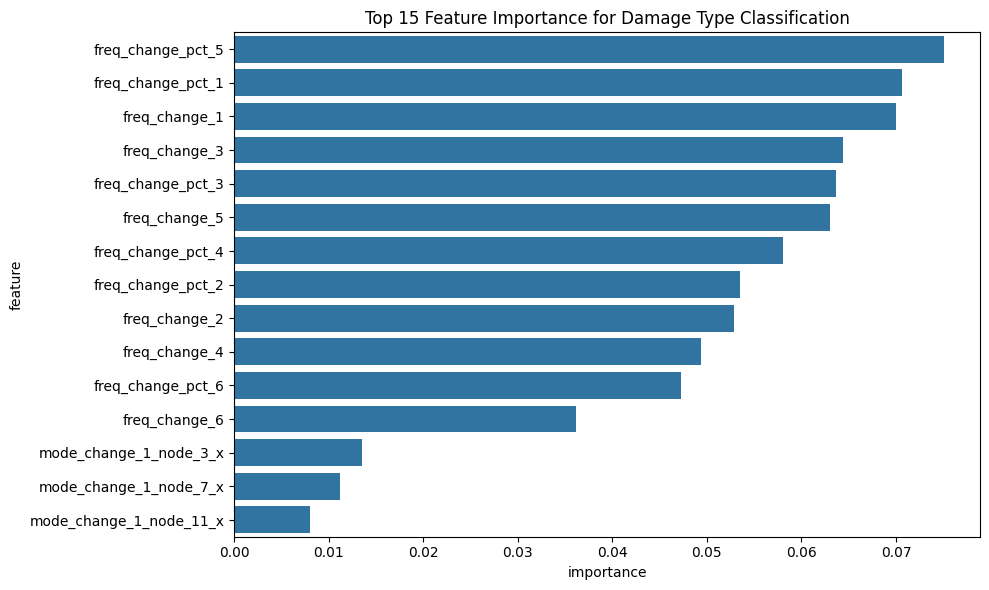


RANDOM FOREST REGRESSION FOR TOTAL DAMAGE SEVERITY
Mean Squared Error (MSE): 2.97
R-squared (R2): 0.96
Out-of-Bag R-squared: 0.96


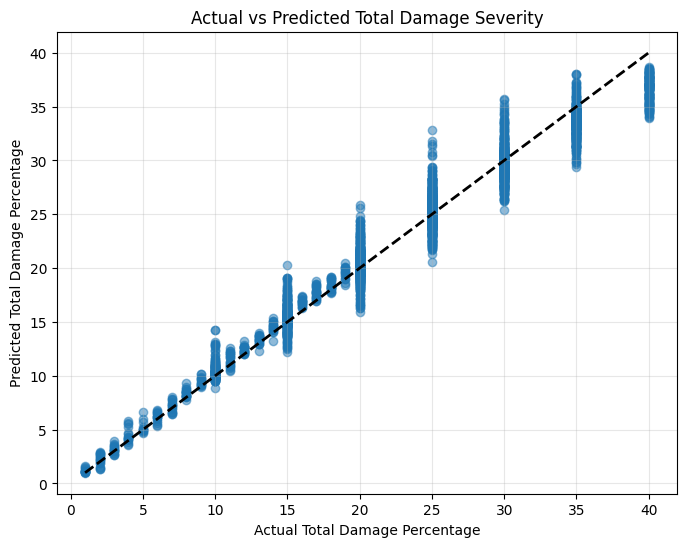


Example Prediction (using a sample from the test set):
  Actual Damage Type: two_elements
  Actual Damaged Elements: [2, 15]
  Actual Damage Percentages: [15, 20]
  Actual Total Severity: 35.0%
  Predicted Damage Type: two_elements (Confidence: 0.995)
  Predicted Total Severity: 33.0%

End of Extended ML Analysis.


In [4]:
# Machine Learning Code for Structural Health Monitoring using Extended Dataset

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import json
import ast # Import ast to safely evaluate the string representation of lists

print("="*60)
print("STRUCTURAL HEALTH MONITORING ML ANALYSIS (EXTENDED DATASET)")
print("="*60)

# Load element info to map element numbers to names
try:
    with open('element_info.json', 'r') as f:
        element_info = json.load(f)
    # Create a map that includes single elements and pairs (as strings or tuples)
    element_map = {int(k): f"Element {k} ({v['type']})" for k, v in element_info.items()}
    element_map[0] = 'Healthy Structure' # For single element damage
    # For two element damage, we'll use the list representation from the dataframe
    print("✓ Element information loaded.")
except FileNotFoundError:
    print("Error: 'element_info.json' not found.")
    print("Please run the data generation cell first.")
    exit()

# Load the extended dataset
try:
    df = pd.read_csv('structural_health_monitoring_dataset_extended.csv')
    # Ensure 'damaged_elements' and 'damage_percentages' are treated as lists
    df['damaged_elements'] = df['damaged_elements'].apply(ast.literal_eval)
    df['damage_percentages'] = df['damage_percentages'].apply(ast.literal_eval)
    print(f"✓ Extended Dataset loaded successfully: {df.shape}")
except FileNotFoundError:
    print("Error: 'structural_health_monitoring_dataset_extended.csv' not found.")
    print("Please run the data generation cell with extended scenarios first.")
    exit()

# --- Prepare Features (X) and Targets (y) ---

# Features: Frequency Changes, Mode Shape Changes, and Temperature Factor
feature_cols = [col for col in df.columns if col.startswith('freq_change_') or col.startswith('mode_change_')]
feature_cols.append('temperature_factor') # Include temperature as a feature

X = df[feature_cols].values

# Targets:
# 1. Damage Type (Healthy, Single Element, Two Elements) - Classification
# 2. Total Damage Severity (Sum of percentages) - Regression

y_damage_type = df['damage_type'].values
# Calculate total severity directly from the 'damage_percentages' list column
y_total_severity = df['damage_percentages'].apply(sum).values


# Encode damage type labels for classification
label_encoder = LabelEncoder()
y_damage_type_encoded = label_encoder.fit_transform(y_damage_type)
damage_type_classes = label_encoder.classes_ # Get the original class names


print(f"\nFeature matrix shape: {X.shape}")
print(f"Features selected ({len(feature_cols)}): {feature_cols[:5]} ... {feature_cols[-5:]}") # Print a sample of feature names
print(f"Damage Type target shape: {y_damage_type_encoded.shape}")
print(f"Total Severity target shape: {y_total_severity.shape}")


# --- Machine Learning Models ---

# Model 1: Random Forest Classifier for Damage Type Classification
print("\n" + "="*60)
print("RANDOM FOREST CLASSIFICATION FOR DAMAGE TYPE")
print("="*60)

# Split data for classification
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y_damage_type_encoded, test_size=0.3, random_state=42, stratify=y_damage_type_encoded # Use encoded labels for stratify
)

# Scale features for classification
scaler_clf = StandardScaler()
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

# Train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf_classifier.fit(X_train_clf_scaled, y_train_clf)

# Make predictions
y_pred_clf = rf_classifier.predict(X_test_clf_scaled)

# Evaluate Classification Model
print("\nClassification Report:")
print(classification_report(y_test_clf, y_pred_clf, target_names=damage_type_classes, zero_division=0))

print("\nAccuracy Score:", accuracy_score(y_test_clf, y_pred_clf))


# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_clf, y_pred_clf)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=damage_type_classes, yticklabels=damage_type_classes)
plt.title('Confusion Matrix for Damage Type Classification')
plt.xlabel('Predicted Damage Type')
plt.ylabel('True Damage Type')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Feature Importance Visualization for Damage Type
plt.figure(figsize=(10, 6))
feature_importance_clf = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

sns.barplot(data=feature_importance_clf.head(15), x='importance', y='feature')
plt.title('Top 15 Feature Importance for Damage Type Classification')
plt.tight_layout()
plt.show()


# Model 2: Random Forest Regressor for Total Damage Severity Prediction
print("\n" + "="*60)
print("RANDOM FOREST REGRESSION FOR TOTAL DAMAGE SEVERITY")
print("="*60)

# Filter out healthy cases for regression (severity is only for damaged cases)
df_damaged = df[df['damage_type'] != 'healthy'].copy()
X_severity = df_damaged[feature_cols].values
y_severity = df_damaged['damage_percentages'].apply(sum).values # Calculate severity for damaged cases


# Split data for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_severity, y_severity, test_size=0.3, random_state=42
)

# Scale features for regression (use a new scaler or the same, consistency is key)
scaler_reg = StandardScaler() # Using a separate scaler for clarity, could use scaler_clf
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)


# Train the Random Forest Regressor model
rf_regressor = RandomForestRegressor(n_estimators=200, random_state=42, oob_score=True)
rf_regressor.fit(X_train_reg_scaled, y_train_reg)

# Make predictions
y_pred_reg = rf_regressor.predict(X_test_reg_scaled)

# Evaluate Regression Model
mse = mean_squared_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)
oob_score = rf_regressor.oob_score_

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2): {r2:.2f}")
print(f"Out-of-Bag R-squared: {oob_score:.2f}")

# Scatter plot of actual vs predicted severity
plt.figure(figsize=(8, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--', lw=2)
plt.xlabel('Actual Total Damage Percentage')
plt.ylabel('Predicted Total Damage Percentage')
plt.title('Actual vs Predicted Total Damage Severity')
plt.grid(True, alpha=0.3)
plt.show()


# --- Example Prediction Function (Updated) ---

def predict_damage_extended(features):
    """
    Predict damage type and total severity for new data using the extended models.
    Input: list or numpy array of feature values (must match the order in feature_cols, including temperature_factor)
    Output: Predicted damage type (string), Predicted total severity percentage (float)
    """
    # Ensure input is a numpy array and has the correct shape (1, n_features)
    input_data = np.asarray(features).reshape(1, -1)

    # Scale the input data using the classifier's scaler (features are the same)
    input_scaled = scaler_clf.transform(input_data)

    # Predict damage type (classification)
    predicted_type_encoded = rf_classifier.predict(input_scaled)[0]
    predicted_damage_type = label_encoder.inverse_transform([predicted_type_encoded])[0]
    type_confidence = rf_classifier.predict_proba(input_scaled)[0].max()

    # Predict total damage severity (regression)
    # The regressor was trained only on damaged cases.
    # We can predict severity regardless of predicted type, but interpret it based on the type.
    predicted_total_severity = rf_regressor.predict(input_scaled)[0]
    # Clamp severity to a reasonable range (e.g., 0-40% for two elements up to 20% each)
    predicted_total_severity = max(0.0, min(40.0, predicted_total_severity))


    return predicted_damage_type, predicted_total_severity, type_confidence

# Example Prediction using a sample from the extended dataset
# Pick a sample from the test set for regression (damaged case)
example_test_index = X_test_reg.shape[0] // 2 # Pick a middle sample from the regression test set
example_features = X_test_reg[example_test_index]
actual_severity = y_test_reg[example_test_index]

# To get the original row info, we need the index from the *original* df
# that corresponds to this row in the X_test_reg set.
# We can achieve this by getting the indices of the df_damaged dataframe
# that went into the X_test_reg split.
original_df_indices_damaged = df_damaged.index # Get indices of the filtered dataframe
# Get the indices used in the test split of the *damaged* data
indices_train_reg, indices_test_reg = train_test_split(
    original_df_indices_damaged, test_size=0.3, random_state=42 # Split the indices
)

# Get the original index of the example row
original_index_of_example = indices_test_reg[example_test_index]

# Get the original row from the full dataframe using this index
original_row = df.loc[original_index_of_example]


actual_damage_type = original_row['damage_type']
actual_damaged_elements = original_row['damaged_elements']
actual_damage_percentages = original_row['damage_percentages']


print(f"\nExample Prediction (using a sample from the test set):")
print(f"  Actual Damage Type: {actual_damage_type}")
print(f"  Actual Damaged Elements: {actual_damaged_elements}")
print(f"  Actual Damage Percentages: {actual_damage_percentages}")
print(f"  Actual Total Severity: {actual_severity:.1f}%")


pred_damage_type, pred_total_severity, confidence = predict_damage_extended(example_features)

print(f"  Predicted Damage Type: {pred_damage_type} (Confidence: {confidence:.3f})")
print(f"  Predicted Total Severity: {pred_total_severity:.1f}%")


print("\nEnd of Extended ML Analysis.")